In [457]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport


In [458]:
df = pd.read_csv('/Users/traulosspyros/Desktop/Big Blue Data Academy/spyros-travlos-exercises/Projects/P3-Classification ML/Data/healthcare-dataset-processed.csv')

In [459]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,smoker,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.89,non-smoker,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,non-smoker,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smoker,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,non-smoker,1


<AxesSubplot:>

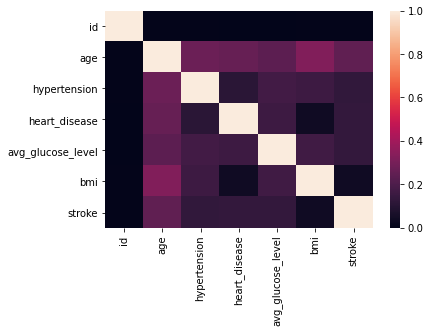

In [460]:
sns.heatmap(df.corr())

In [461]:
ProfileReport(df, title = 'Pandas Profiling Report')

let's only keep male and female in gender, as the 'other' only has one value. We will replace it with male

In [462]:
df['gender']=df['gender'].str.replace('Other', 'Male')

### We see from above that avg_glucose, bmi are skewed


<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

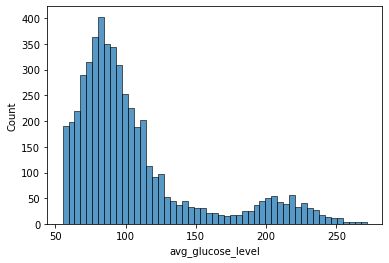

In [463]:
sns.histplot(data = df, x = df['avg_glucose_level'])

<AxesSubplot:xlabel='bmi', ylabel='Count'>

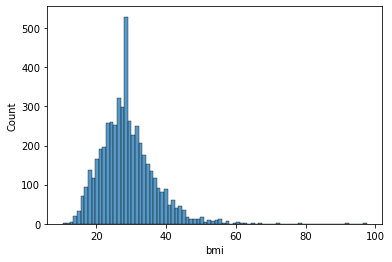

In [464]:
sns.histplot(data = df, x = df['bmi'])

### For that let's log tranform these two features and see their distribution again

In [465]:
df['avg_glucose_level'] = np.log(df['avg_glucose_level'])
df['bmi'] = np.log(df['bmi'])

In [466]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,5.432367,3.600048,smoker,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,5.309307,3.363496,non-smoker,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,4.662684,3.481240,non-smoker,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,5.143008,3.538057,smoker,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,5.159745,3.178054,non-smoker,1


<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

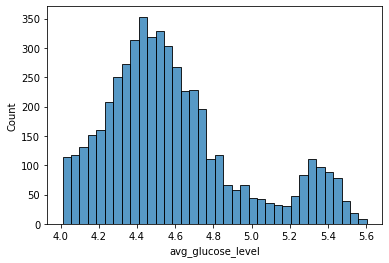

In [467]:
sns.histplot(data = df, x = df['avg_glucose_level'])

<AxesSubplot:xlabel='bmi', ylabel='Count'>

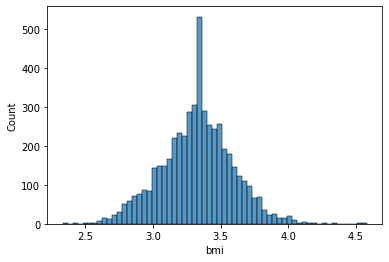

In [468]:
sns.histplot(data = df, x = df['bmi'])

#### Hence we have managed to make the distributions of these two features better

In [469]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['smoking_status'])
df['smoking_status'] = le.transform(df['smoking_status'])

le.fit(df['residence_type'])
df['residence_type'] = le.transform(df['residence_type'])

le.fit(df['ever_married'])
df['ever_married'] = le.transform(df['ever_married'])

le.fit(df['work_type'])
df['work_type'] = le.transform(df['work_type'])

le.fit(df['gender'])
df['gender'] = le.transform(df['gender'])

df = pd.get_dummies(df)

In [470]:
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,5.432367,3.600048,2,1
1,51676,0,61.0,0,0,1,3,0,5.309307,3.363496,1,1
2,31112,1,80.0,0,1,1,2,0,4.662684,3.481240,1,1
3,60182,0,49.0,0,0,1,2,1,5.143008,3.538057,2,1
4,1665,0,79.0,1,0,1,3,0,5.159745,3.178054,1,1


In [471]:
df.index = df['id'] # We make the id column the index of the dataframe

In [472]:
df.drop(columns = 'id', inplace = True) # we drop the id column

### Check for outliers. 

<AxesSubplot:>

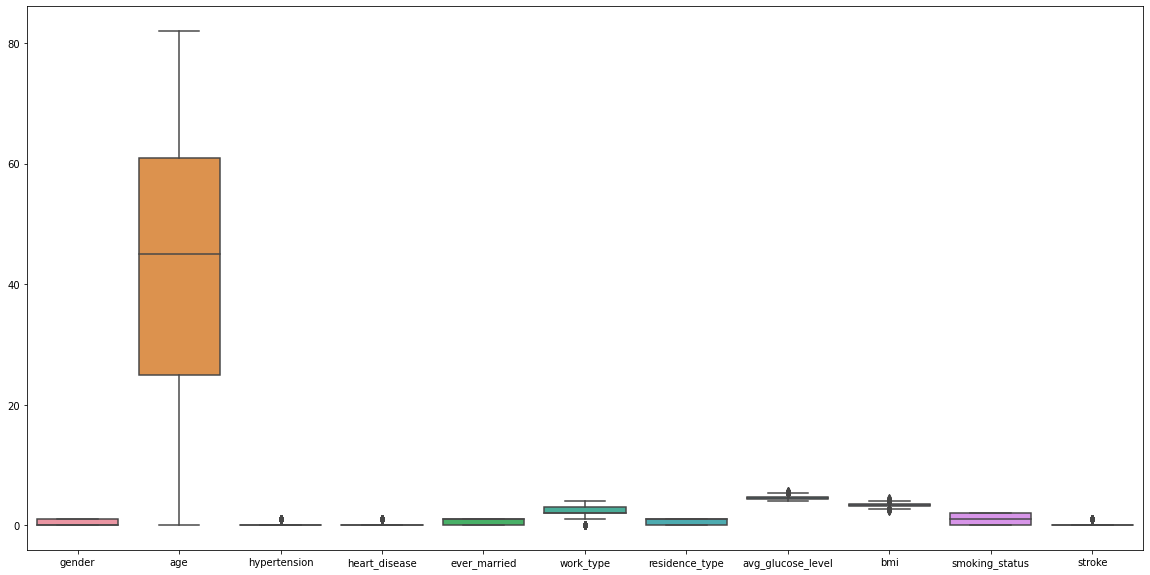

In [473]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data = df)

### From the above figure we see that age will definitely need to be scaled. We will use scaling in our pipeline.

### Check if the dataset is imbalanced

In [474]:
df['stroke'].value_counts() # we have an imbalanced dataset

0    4861
1     249
Name: stroke, dtype: int64

In [475]:
import plotly.express as px

fig = px.bar(df['stroke'].value_counts())
fig.show()

 We have an imbalanced dataset. Since we do not have a vast number of data, we will use oversampling

In [476]:
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
X = df.drop(columns = 'stroke')
y = df['stroke']

In [477]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 1)
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print('Before oversampling', Counter(y_train))
print('After oversampling', Counter(y_train_over))

Before oversampling Counter({0: 3658, 1: 174})
After oversampling Counter({0: 3658, 1: 3658})


In [478]:
import shap
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(class_weight='balanced')
classifier.fit(X_train_over, y_train_over)
predictions = classifier.predict(X_test)

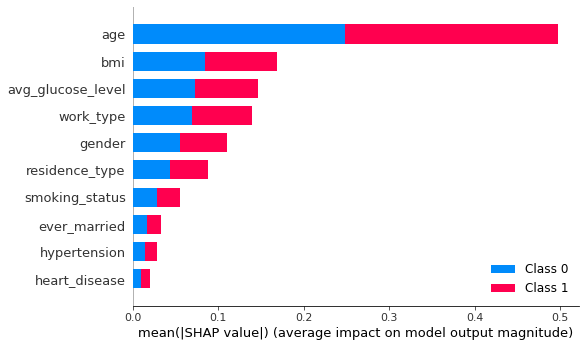

In [479]:
shap_values = shap.TreeExplainer(classifier).shap_values(X_train_over, approximate=True)
shap.summary_plot(shap_values, X_train_over, plot_type="bar")

### We will now try some models to see which one gives the best result. Our metric will be the f1 score

We will try SVM, KNN and Random Forest with grid search for hyperparameter tuning

In [480]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

In [481]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures, RobustScaler


## 1) KNN

In [482]:
pipe_knn = Pipeline([('scaler', RobustScaler()),
                 ('model', KNeighborsClassifier())
                 ])
pipe_knn.fit(X_train_over, y_train_over)
preds_knn = pipe_knn.predict(X_test)


In [483]:
f1_knn = f1_score(y_test, preds_knn)

In [484]:
accuracy_knn = accuracy_score(y_test, preds_knn)

In [485]:
print(classification_report(y_test, preds_knn))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1203
           1       0.13      0.47      0.21        75

    accuracy                           0.79      1278
   macro avg       0.55      0.64      0.54      1278
weighted avg       0.91      0.79      0.84      1278



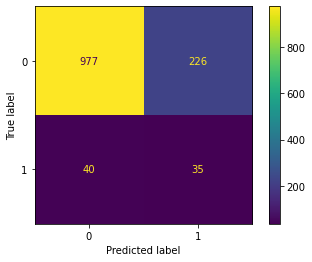

In [486]:
plot_confusion_matrix(pipe_knn,X_test, y_test)

## 2) Random Forest

In [487]:
#Let's try RandomForest
pipe_rf = Pipeline([('scaler', RobustScaler()),('model', RandomForestClassifier(random_state = 1))])
pipe_rf.fit(X_train_over, y_train_over)
preds_rf = pipe_rf.predict(X_test)

In [488]:
f1_rf = f1_score(y_test, preds_rf)

In [489]:
accuracy_rf = accuracy_score(y_test, preds_rf)


In [490]:
print(classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1203
           1       0.15      0.24      0.18        75

    accuracy                           0.87      1278
   macro avg       0.55      0.58      0.56      1278
weighted avg       0.90      0.87      0.89      1278



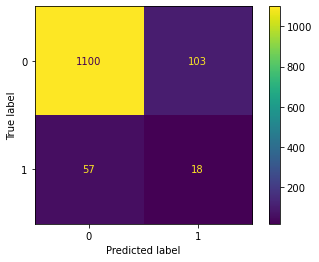

In [491]:
plot_confusion_matrix(pipe_rf,X_test, y_test)

## 3) SVM

In [492]:
#Let's try svm
pipe_svm = Pipeline([('scaler', RobustScaler()),('model', SVC(random_state = 2))])
pipe_svm.fit(X_train_over, y_train_over)
preds_svm = pipe_svm.predict(X_test)

In [493]:
f1_svm = f1_score(y_test, preds_svm)

In [494]:
accuracy_svm = accuracy_score(y_test, preds_svm)

In [495]:
print(classification_report(y_test, preds_svm))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1203
           1       0.13      0.45      0.20        75

    accuracy                           0.79      1278
   macro avg       0.54      0.63      0.54      1278
weighted avg       0.91      0.79      0.84      1278



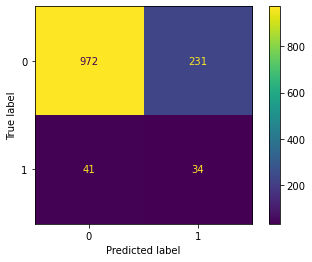

In [496]:
plot_confusion_matrix(pipe_svm,X_test, y_test)

## 4) Gradient Boosting

In [497]:
from sklearn.ensemble import GradientBoostingClassifier


In [498]:
pipe_gb = Pipeline([('scaler', RobustScaler()), ('model', GradientBoostingClassifier(random_state = 3))])
pipe_gb.fit(X_train_over, y_train_over)
preds_gb = pipe_gb.predict(X_test)

In [499]:
f1_gb = f1_score(y_test, preds_gb)

In [500]:
accuracy_gb = accuracy_score(y_test, preds_gb)

In [501]:
print(classification_report(y_test, preds_gb))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1203
           1       0.13      0.43      0.20        75

    accuracy                           0.80      1278
   macro avg       0.54      0.62      0.54      1278
weighted avg       0.91      0.80      0.84      1278



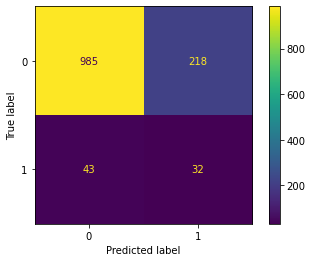

In [502]:
plot_confusion_matrix(pipe_gb, X_test, y_test)

In [503]:
# Let's compare

scores = {'Classifier Name':['KNN', 'Random Forest', 'SVM', 'Gradient Boosting'],
         'Accuracy':[accuracy_knn, accuracy_rf, accuracy_svm, accuracy_gb],
          'F1_score':[f1_knn, f1_rf, f1_svm, f1_gb]
         }

pd.DataFrame(scores)

,Classifier Name,Accuracy,F1_score
0,KNN,0.791862,0.208333
1,Random Forest,0.874804,0.183673
2,SVM,0.787167,0.200000
3,Gradient Boosting,0.795775,0.196923


By looking at the above table as well as the confusion matrices plotted above we can conclude that the best algorithm is SVM. That is due to the nature of our problem. All algorithms are quiet good at finding the 0s i.e. the non stroke patients. However we are more interested in being able to predict as many 1s as possible. Hence knn algorithm is the best